In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from dgfem2d import DGFEM2D

%matplotlib notebook 

In [2]:
Lx, Ly = 1.0, 1.0

nx, ny = 5, 5

#x = np.tile(np.linspace(0.0, Lx, nx, endpoint=True), ny)
#print "x:" + str(x)

#y_range = np.linspace(0.0, Ly, ny, endpoint=True)

#y = np.concatenate([np.repeat(yp, nx) for yp in y_range])
#print "y:" + str(y)

#assert len(y)==len(x)

#x, y = np.array([0.0, Lx, 0.0, Lx, Lx/2]), np.array([-Ly, -Ly+0.8, Ly, Ly-0.8, 0.0])
x, y = np.array([0.0, Lx, 0.0, Lx]), np.array([0.0, 0.0, Ly, Ly])


In [3]:
import matplotlib.tri as tri

triang = tri.Triangulation(x, y)

#EtoV = triang.triangles
#VX, VY = triang.x, triang.y

refiner = tri.UniformTriRefiner(triang)

triang_refined = refiner.refine_triangulation(subdiv=1)


VX, VY = triang_refined.x, triang_refined.y

EtoV = triang_refined.triangles


In [4]:
N = 12

fem = DGFEM2D(VX, VY, EtoV, N)

<IPython.core.display.Javascript object>


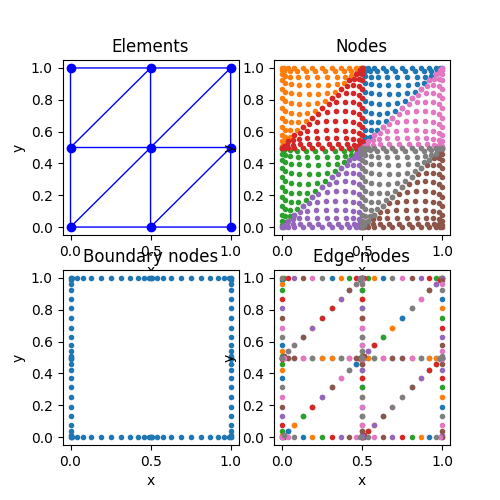

In [5]:
plt.figure(figsize=(5,5))

plt.subplot(2,2,1)
plt.triplot(triang_refined, 'bo-', lw=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Elements')

plt.subplot(2,2,2)
plt.plot(fem.X, fem.Y, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Nodes')

plt.subplot(2,2,3)
plt.plot(fem.X[fem.vmapB], fem.Y[fem.vmapB], '.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Boundary nodes')

plt.subplot(2,2,4)
plt.plot(fem.X[fem.vmapM], fem.Y[fem.vmapM], '.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Edge nodes')

plt.show()

<IPython.core.display.Javascript object>


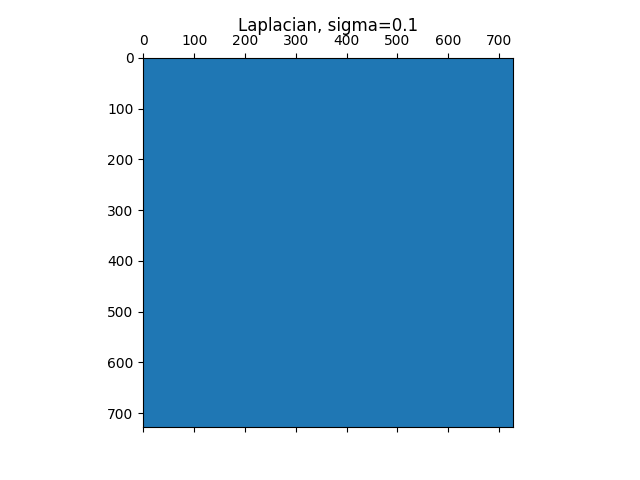

In [6]:
import numpy as np

sigma = 0.1

def grad_operator(vec):
    u = vec.reshape(fem.X.shape, order='F')
    
    du = u[fem.vmapM] - u[fem.vmapP]
    du[fem.mapB] = 2*u[fem.vmapB]

    dudx, dudy = fem.grad(u)
    
    gradu_x = dudx - np.matmul(fem.lift, fem.Fscale*fem.nx*du/2)
    gradu_y = dudy - np.matmul(fem.lift, fem.Fscale*fem.ny*du/2)
    
    grad = np.concatenate([ gradu_x.ravel(order='F'), 
                            gradu_y.ravel(order='F')])
    
    return grad

def div_operator(vec):
    qx = vec[:len(vec)//2].reshape(fem.X.shape, order='F')
    qy = vec[len(vec)//2:].reshape(fem.X.shape, order='F')
    
    dqx = qx[fem.vmapM] - qx[fem.vmapP]
    dqy = qy[fem.vmapM] - qy[fem.vmapP]
    
    divq = fem.div(qx, qy) - np.matmul(fem.lift, fem.Fscale*(fem.nx*dqx + fem.ny*dqy)/2.0)
    
    return divq.ravel(order='F')

def stabilizer_operator(vec):
    pass
    

def A_operator(vec):
    u = vec[:len(vec) // 3].reshape(fem.X.shape, order='F')
    
    du = u[fem.vmapM] - u[fem.vmapP]
    du[fem.mapB] = 2*u[fem.vmapB]

    dudx, dudy = fem.grad(u)
    
    gradu_x = dudx - np.matmul(fem.lift, fem.Fscale*fem.nx*du/2)
    gradu_y = dudy - np.matmul(fem.lift, fem.Fscale*fem.ny*du/2)

    qx = vec[len(vec) // 3 : 2*len(vec) // 3].reshape(fem.X.shape, order='F')
    qy = vec[2*len(vec) // 3:].reshape(fem.X.shape, order='F')
    
    dqx = qx[fem.vmapM] - qx[fem.vmapP]
    dqy = qy[fem.vmapM] - qy[fem.vmapP]
    
    divq = fem.div(qx, qy) - np.matmul(fem.lift, fem.Fscale*(fem.nx*dqx + fem.ny*dqy + sigma*du)/2.0)
    
    A = np.concatenate([(gradu_x - qx).ravel(order='F'), 
                        (gradu_y - qy).ravel(order='F'),
                         divq.ravel(order='F')])
    
    return A
    
def M_operator(vec):
    return np.concatenate([vec[len(vec) // 3:], vec[:len(vec) // 3]])
    
    

def lap(uu, sigma=1.0):
    u = uu.reshape(fem.X.shape, order='F')
    
    du = u[fem.vmapM] - u[fem.vmapP]
    du[fem.mapB] = 2*u[fem.vmapB]

    dudx, dudy = fem.grad(u)

    fluxxu = fem.nx*du/2.0
    fluxyu = fem.ny*du/2.0

    qx = dudx - np.matmul(fem.lift, fem.Fscale*fluxxu)
    qy = dudy - np.matmul(fem.lift, fem.Fscale*fluxyu)

    dqx = qx[fem.vmapM] - qx[fem.vmapP]
    dqy = qy[fem.vmapM] - qy[fem.vmapP]

    fluxq = (fem.nx*dqx + fem.ny*dqy + sigma*du)/2.0
    #fluxq = fem.nx*(qx[fem.vmapM] - 0.5*(dudx[fem.vmapM]+dudx[fem.vmapP])) +\
    #        fem.ny*(qy[fem.vmapM] - 0.5*(dudy[fem.vmapM]+dudy[fem.vmapP])) + sigma*du
    
    divq = fem.div(qx, qy)

    lapu = divq #- np.matmul(fem.lift, fem.Fscale*fluxq)

    return lapu.ravel(order='F')

import scipy.sparse.linalg as sparse
from scipy.sparse import csr_matrix

#lap_op = sparse.LinearOperator((fem.K*fem.Np, fem.K*fem.Np), matvec=lap)
#lap_mat = lap_op.matmat(np.eye(fem.K*fem.Np))

grad_op = sparse.LinearOperator((2*fem.K*fem.Np, fem.K*fem.Np), matvec=grad_operator)
div_op = sparse.LinearOperator((fem.K*fem.Np, 2*fem.K*fem.Np), matvec=div_operator)

lap_mat = (div_op *grad_op).matmat(np.eye(fem.K*fem.Np))
#M_mat = M_op.matmat(np.eye(3*fem.K*fem.Np))

fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)

ax1.spy(csr_matrix(lap_mat), precision=0.01, markersize=1)
ax1.set_title('Laplacian, sigma=' + str(sigma))

#ax2.spy(csr_matrix(M_mat), precision=0.01, markersize=1)
#ax2.set_title('M')

plt.show()


In [7]:
nev = 10

vals_all, vecs_all = np.linalg.eig(lap_mat)

idx = np.argsort(np.abs(vals_all))

vals, vecs = vals_all[idx[:nev]], vecs_all[:,idx[:nev]]

#vals, vecs = sparse.eigs(div_op*grad_op, k=nev, sigma=0, which='LM', tol=1e-3)

<IPython.core.display.Javascript object>


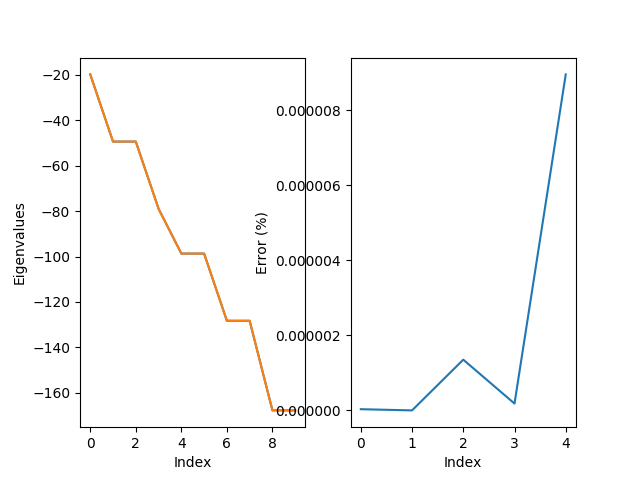

In [8]:
exact = -np.sort([(n**2/Lx**2 + m**2/Ly**2)*np.pi**2 for n in xrange(1,14) for m in xrange(1,14)])[:nev]

errors = np.abs(vals - exact)/np.abs(exact)

plt.figure()

plt.subplot(1,2,1)
plt.plot(np.real(vals))
plt.plot(exact)

plt.xlabel("Index")
plt.ylabel("Eigenvalues")

plt.subplot(1,2,2)
plt.plot(errors[:5])
plt.xlabel("Index")
plt.ylabel("Error (%)")

plt.show()

<IPython.core.display.Javascript object>


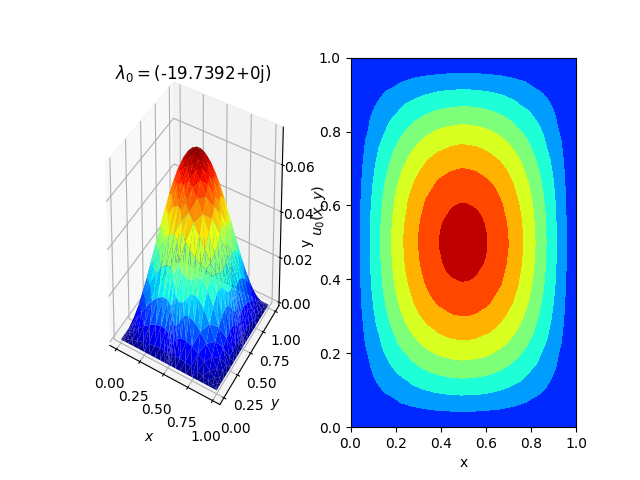

<IPython.core.display.Javascript object>


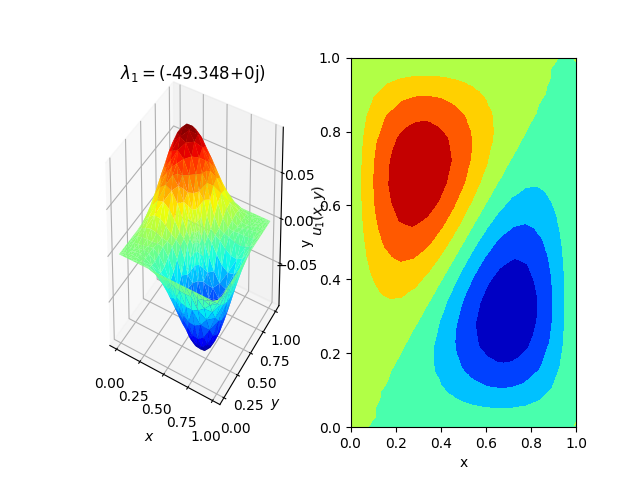

<IPython.core.display.Javascript object>


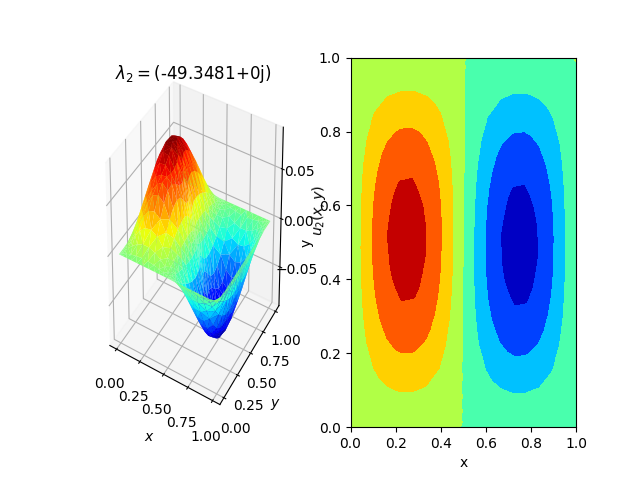

<IPython.core.display.Javascript object>


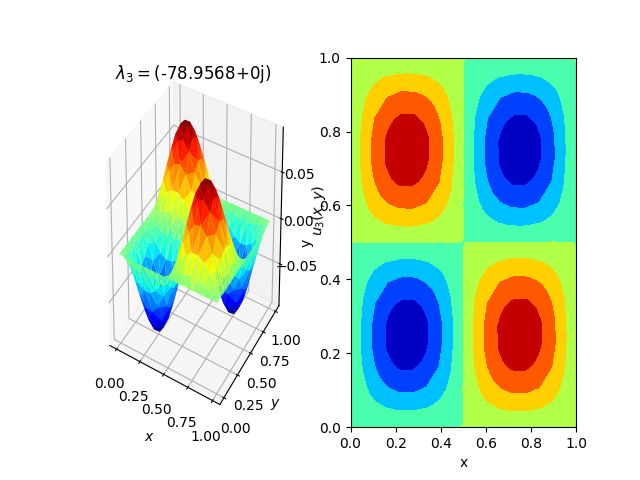

<IPython.core.display.Javascript object>


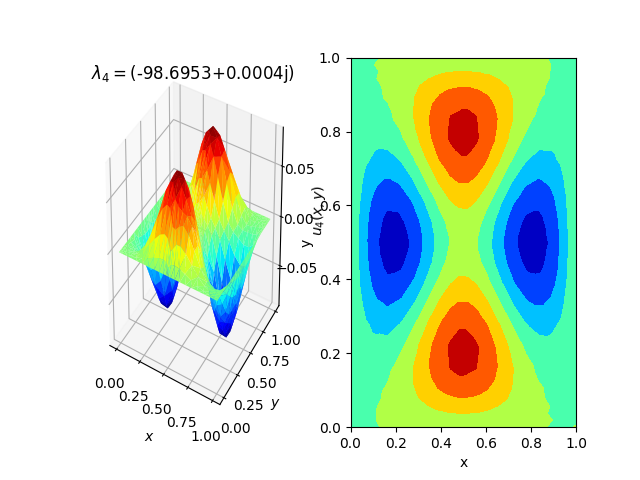

<IPython.core.display.Javascript object>


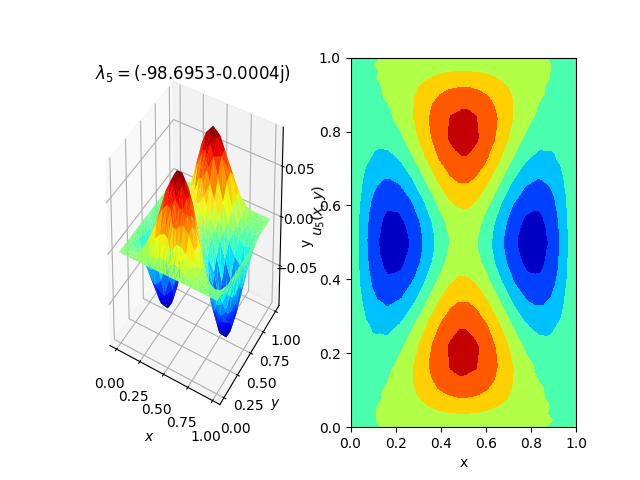

<IPython.core.display.Javascript object>


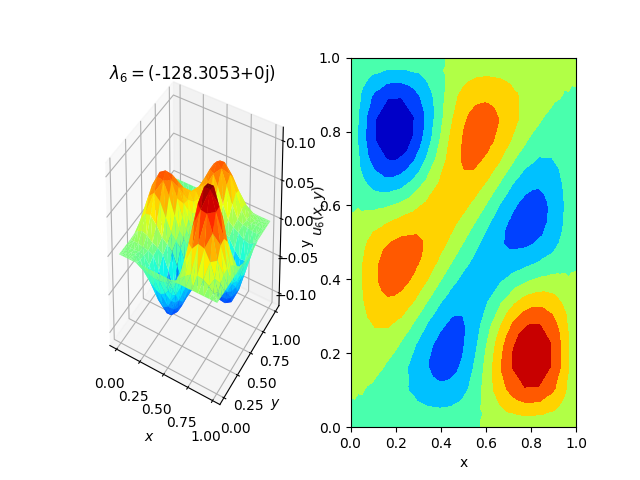

<IPython.core.display.Javascript object>


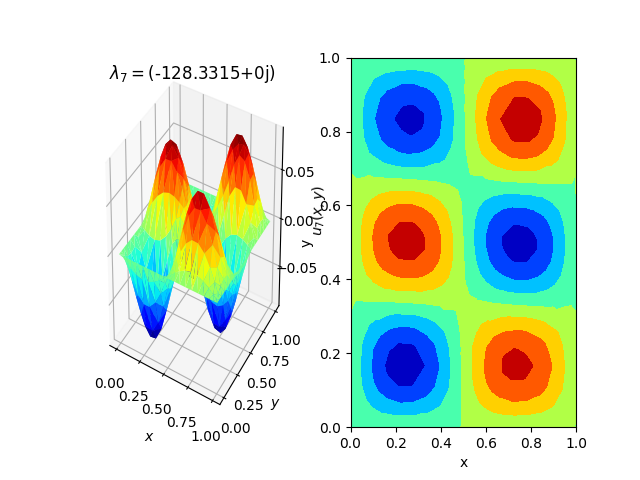

<IPython.core.display.Javascript object>


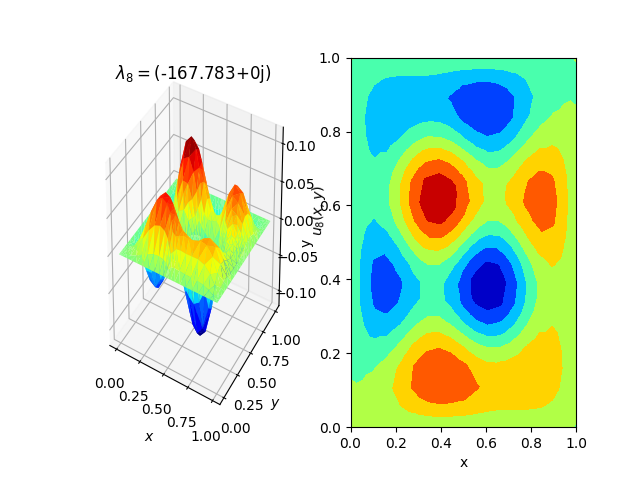

<IPython.core.display.Javascript object>


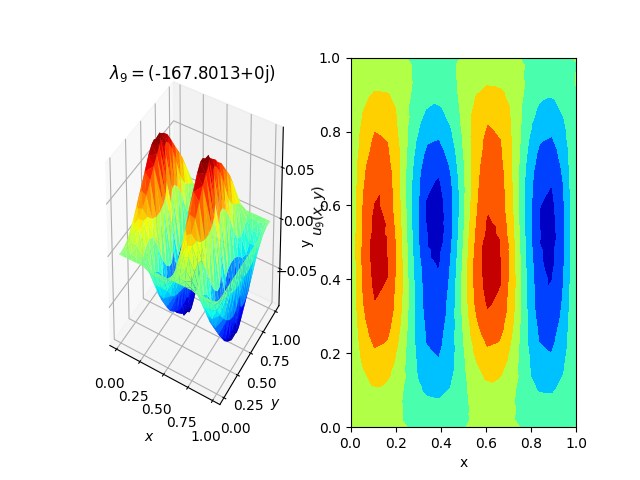

In [9]:
xx, yy = fem.X.ravel(order='F'), fem.Y.ravel(order='F')

fem_tri = tri.Triangulation(xx, yy)

for i in range(nev):
    fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    surf = ax.plot_trisurf(fem_tri, np.real(vecs[:,i]), cmap=cm.jet, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$u_' + str(i) + '(x,y)$')
    ax.set_title('$\lambda_' + str(i) + '=$' + str(np.round(vals[i],4)))
    
    plt.subplot(1,2,2)
    plt.tricontourf(fem_tri, np.real(vecs[:,i]), cmap=cm.jet, linewidth=0)
    plt.xlabel('x')
    plt.ylabel('y')
        
plt.show()